# LAB 2 - Matheus Gomes Maia
## ATIVIDADE
* 1 Reproduza a tabela 4.1 do livro texto calculando as estatísticas para sua coleção (5 pts).
* 2 Reproduza a tabela 4.2 do livro considerando as top-50 palavras mais frequentes de sua coleção (5 pts). 
* 3 Plote curvas de rank-frequência (usando escala logarítmica) para palavras e bigramas na coleção que você coletou na atividade anterior. Quais os melhores valores do parâmetro c para cada curva (5 pts)?
* 4 Reproduza a tabela 4.5 do livro texto considerando a sua coleção (5 pts).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import re
from scipy.optimize import minimize_scalar
import seaborn as sns
pd.set_option("display.max_rows",40)

%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/maia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Data

In [2]:
#Load all news
data = pd.read_csv('results.csv')
data= data.drop_duplicates(subset='url', keep='last')


#Pre process news
# Tokenize, Join and Filter
# Words into a new data Frame
txt = [str(news) for news in data["text"].tolist()]
words = [nltk.word_tokenize(sentence) for sentence in txt]
words = [item for sublist in words for item in sublist] 
words=[word.lower() for word in words if (word.isalpha())] 

# New Data frame with Word, Frequency and Ranking columns 
words_df = pd.DataFrame(words, columns=['word']) #All words
word_counts = words_df.word.value_counts().reset_index() #Join by word. Adds Frequency
word_counts.columns = ['Word', 'Freq'] #Naming columns 
word_counts['word_rank'] = word_counts.Freq.rank(ascending=False) #Adds ranking

## 1 Reproduza a tabela 4.1 do livro texto calculando as estatísticas para sua coleção (5 pts).

In [3]:
#Calculate
total = len(txt) 
total_words = len(words)
vocabulary_size = len(word_counts)
words_thousand = len(word_counts[word_counts['Freq'] > 1000])
words_once = len(word_counts[word_counts['Freq'] == 1])

#Print
labels = ["Total Documents", "Total word occurrences", "Vocabary Size", "Words ocurring > 1000 times", "Words ocurring once"]
values = [total, total_words, vocabulary_size, words_thousand, words_once]
for i in range(len(values)):
    print(labels[i], (30-len(labels[i]))*"-", values[i])

Total Documents --------------- 129
Total word occurrences -------- 55416
Vocabary Size ----------------- 8962
Words ocurring > 1000 times --- 7
Words ocurring once ----------- 4605


## 2 Reproduza a tabela 4.2 do livro considerando as top-50 palavras mais frequentes de sua coleção (5 pts). 

In [4]:
# Prob = Frequency/Total of words
word_counts['Prob. Per cent'] = (word_counts.Freq/total_words)*100
word_counts['Prob'] = word_counts.Freq/total_words

print(word_counts)

              Word  Freq  word_rank  Prob. Per cent      Prob
0               de  2823        1.0        5.094197  0.050942
1                a  2089        2.0        3.769669  0.037697
2                o  1759        3.0        3.174174  0.031742
3              que  1613        4.0        2.910712  0.029107
4                e  1427        5.0        2.575069  0.025751
5               da  1039        6.0        1.874910  0.018749
6               do  1034        7.0        1.865887  0.018659
7               em   862        8.0        1.555507  0.015555
8             para   748        9.0        1.349791  0.013498
9               um   597       10.0        1.077306  0.010773
10             com   574       11.0        1.035802  0.010358
11              no   541       12.0        0.976252  0.009763
12             uma   525       13.0        0.947380  0.009474
13               é   522       14.0        0.941966  0.009420
14             não   510       15.0        0.920312  0.009203
15      

## 3 Plote curvas de rank-frequência (usando escala logarítmica) para palavras e bigramas na coleção que você coletou na atividade anterior. Quais os melhores valores do parâmetro c para cada curva (5 pts)?

In [5]:
#Brigrams
# Nltk to produce bigrams and join both words
bigrm = [' '.join(b) for b in list(nltk.bigrams(words))]
bigrm_df = pd.DataFrame(bigrm, columns=['bigrm'])

# New Data Frame with bigram, frequency and ranking

bigrm_counts = bigrm_df.bigrm.value_counts().reset_index()
bigrm_counts.columns = ['bigrm', 'Freq']
bigrm_counts['bigrm_rank'] = bigrm_counts.Freq.rank(ascending=False)
total_bigrm = len(bigrm_counts.index)
bigrm_counts['Prob'] = bigrm_counts.Freq/total_bigrm

# print(bigrm_counts)

In [6]:
#Find best C usig only mean
word_counts['rPr'] = (word_counts.word_rank*word_counts.Prob)
bigrm_counts['rPr'] = (bigrm_counts.bigrm_rank*bigrm_counts.Prob)


word_counts['C'] = np.mean(word_counts.rPr) / word_counts.Prob
bigrm_counts['C'] = np.mean(bigrm_counts.rPr) / bigrm_counts.Prob


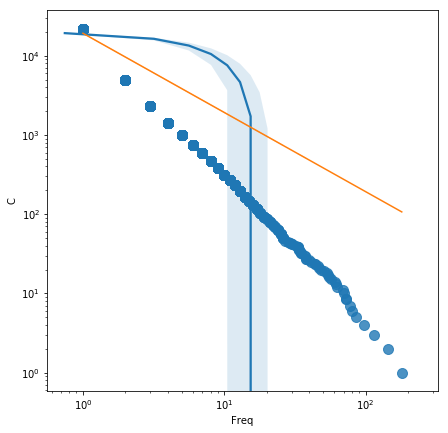

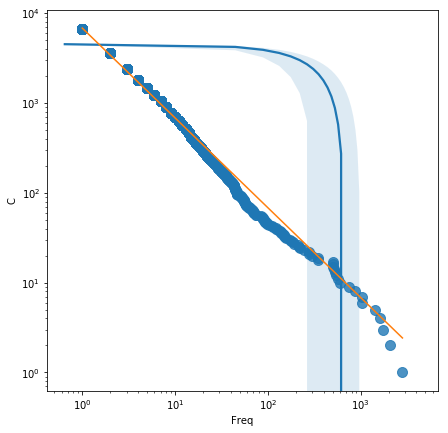

In [7]:
#Plot Rank vs Frequency

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.regplot("Freq", "bigrm_rank", bigrm_counts, ax=ax, scatter_kws={"s": 100})
sns.lineplot(bigrm_counts['Freq'], bigrm_counts['C'])


f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.regplot("Freq", "word_rank", word_counts, ax=ax, scatter_kws={"s": 100})
sns.lineplot(word_counts['Freq'], word_counts['C'])


In [8]:
#Fuction used to calculate Zipf's law coefficient (Freq vs Count)
def loglik(b):  
    # Power law function
    Probabilities = freq_c**(-b)

    # Normalized
    Probabilities = Probabilities/Probabilities.sum()

    # Log Likelihoood
    Lvector = np.log(Probabilities)

    # Multiply the vector by frequencies
    Lvector = np.log(Probabilities) * freq_word_counts

    # LL is the sum
    L = Lvector.sum()

    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)

Melhor valor do parâmetro da lei de Zipf para palavras é:  1.7893394717881137


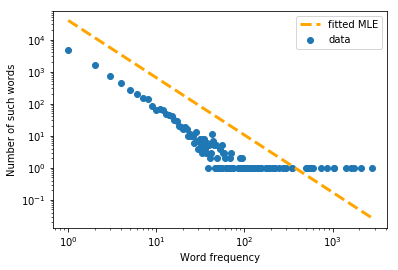

In [9]:
# Group all words with same freq
word_counts_new = word_counts.filter(['Freq','Word'], axis=1)
word_counts_new_group = word_counts_new.groupby(['Freq'], as_index=False).count()

# Lists of frequencys and number of words for each frequency
freq_c = np.asarray(word_counts_new_group['Freq'])
freq_word_counts = np.asarray(word_counts_new_group['Word'])

# Find best c
s_best = minimize_scalar(loglik, [0.01, 4.0] )


f,ax = plt.subplots()
ax.scatter(freq_c, freq_word_counts, label = "data")
ax.set_xlabel('Word frequency')
ax.set_ylabel('Number of such words')
ax.set_xscale("log")
ax.set_yscale("log")


ax.plot(freq_c[0:2*10**2], 4*10**4*freq_c[0:2*10**2]**-s_best.x, '--', color="orange", lw=3, label = "fitted MLE")
ax.legend()
print("Melhor valor do parâmetro da lei de Zipf para palavras é: ", s_best.x)

Melhor valor do parâmetro da lei de Zipf para bigramas é:  2.8235678531589214


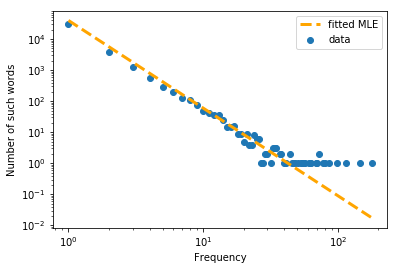

In [10]:
# Group all bigrams with same freq
bigrm_counts_new = bigrm_counts.filter(['Freq','bigrm'], axis=1)
bigrm_counts_new_group = bigrm_counts_new.groupby(['Freq'], as_index=False).count()

# Lists of frequencys and number of bigrams for each frequency
freq_c = np.asarray(bigrm_counts_new_group['Freq'])
freq_word_counts = np.asarray(bigrm_counts_new_group['bigrm'])

# Find best  zipf constant
s_best = minimize_scalar(loglik, [0.01, 4.0] )

#Plot
f,ax = plt.subplots()
ax.scatter(freq_c, freq_word_counts, label = "data")
ax.set_xlabel('Frequency')
ax.set_ylabel('Number of such words')
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(freq_c[0:2*10**2], 4*10**4*freq_c[0:2*10**2]**-s_best.x, '--', color="orange", lw=3, label = "fitted MLE")
ax.legend()
print("Melhor valor do parâmetro da lei de Zipf para bigramas é: ", s_best.x)

## 4 Reproduza a tabela 4.5 do livro texto considerando a sua coleção (5 pts).

In [11]:
# Group by Freq
word_counts_new = word_counts.filter(['Freq','Word'], axis=1)
word_counts_groupby = word_counts_new.groupby(['Freq'], as_index=False).count()

#Add new columns 
word_counts_groupby['Predicted Prop'] = 1/(word_counts_groupby.Freq*(word_counts_groupby.Freq+1))
word_counts_groupby['Actual Prop'] = word_counts_groupby.Word/vocabulary_size
word_counts_groupby['Actual Number of Words'] = word_counts_groupby.Word

#Print
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(word_counts_groupby)

     Freq  Word  Predicted Prop  Actual Prop  Actual Number of Words
0       1  4605           0.500        0.514                    4605
1       2  1572           0.167        0.175                    1572
2       3   749           0.083        0.084                     749
3       4   448           0.050        0.050                     448
4       5   265           0.033        0.030                     265
5       6   205           0.024        0.023                     205
6       7   152           0.018        0.017                     152
7       8   143           0.014        0.016                     143
8       9    87           0.011        0.010                      87
9      10    66           0.009        0.007                      66
10     11    71           0.008        0.008                      71
11     12    66           0.006        0.007                      66
12     13    49           0.005        0.005                      49
13     14    44           0.005   